In [1]:
import os
import numpy as np
import scipy as sp
import scipy.io as spio
import itertools as it
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import sklearn as sk
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import fowlkes_mallows_score
from sklearn.svm import SVC, NuSVC
from sklearn.linear_model import LinearRegression, Lasso, Ridge, LogisticRegression
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import VotingClassifier, RandomForestClassifier
from sklearn.random_projection import GaussianRandomProjection
from sklearn.neighbors import KNeighborsClassifier, NearestCentroid
from sklearn.neural_network import MLPClassifier
from sklearn.exceptions import DataConversionWarning, ConvergenceWarning
from sklearn.decomposition import FastICA, PCA
from rich.progress import track
import warnings
import mne
warnings.filterwarnings(action='ignore', category=DataConversionWarning)
warnings.filterwarnings(action='ignore', category=ConvergenceWarning)


rawData = {
    file[:-4]: {k: v for k, v in spio.loadmat(os.path.join(path, file)).items() if not k.startswith('__')}
    for path, dirs, files in os.walk('.') for file in files if file.endswith('.mat')
}

# 24 Channels
# (24,)
ChannelName = [i[0][0] for i in rawData['ChanName']['ChanName'][:,0]]

# 54 Channel Pairs
# (54, 2) Channel Index
ChannelPair = rawData['Pair54']['Pair54']

# 19 Channels In Use
# a map from 1~19 to 1~24
ChannelMap = dict(enumerate(it.chain(range(1,9), range(10,17), range(19,21), range(23,25)), 1))
ChannelMap_inv = {v: k for k, v in ChannelMap.items()}

# Sample Time 
Ts = 7

# Raw Sample Frequency 300Hz
# 2100 sample points
Fs = 300

# Compressed Sample Frequency 5Hz
# (36,)
# unit: s
TimeStep = rawData['OSPerson1']['Time'][0]

# Frequency
# (52,)
fOS = rawData['OSPerson1']['fOS'][:,0]

Person: list[dict[str, np.ndarray]] = [
    {
        # (40 or 10, 54, 52, 36)
        # (trial, channel pair, frequency, compressed timestep) float64
        'OS': np.transpose(rawData[f'OSPerson{i}']['OS'], [2, 3, 1, 0]),    
        # (40 or 10,) bool
        # (trial,)
        'Label': rawData[f'OSPerson{i}']['Track'][0] <= 10,           
        # (40 or 10, 19, 2100) float64
        # (trial, channel, raw timestep)
        'raw': np.transpose(rawData[f'rawTracePerson{i}']['dataTrial'], [1, 2, 0]),
    }
    for i in range(1, 5)
]

In [2]:
def train_and_test(X, y, classifier, N=100, test_size=0.2, stratify=None, verbose=True):
    test_accs = np.empty(N)
    for i in range(N):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=i, stratify=stratify)
        test_accs[i] = classifier.fit(X_train, y_train).score(X_test, y_test)
    mean_test_acc = np.mean(test_accs)
    if verbose:
        print(f'{N} tests mean accuracy: {mean_test_acc:.1%}')
    return mean_test_acc

# Seperate Design

## Person1

100 tests mean accuracy: 95.8%

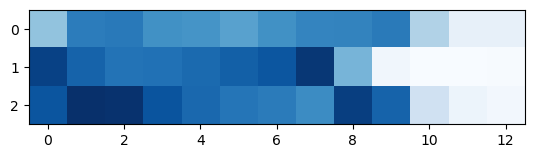

In [3]:
# Preprocessing
freq = [0, 28, 29, 32, 33, 36, 37, 38, 47, 48, 49, 50, 51]
pair = [1, 42, 48]
X = Person[0]['OS']
y = Person[0]['Label']
X = X[:,pair][:,:,freq]
X = np.mean(X, axis=-1)
X = X.reshape(X.shape[0], -1)

classifier = SVC(C=6)
train_and_test(X, y, classifier, stratify=y)

plt.imshow(X[0].reshape(3, 13), cmap='Blues_r')
plt.show()

## Person2

100 tests mean accuracy: 100.0%

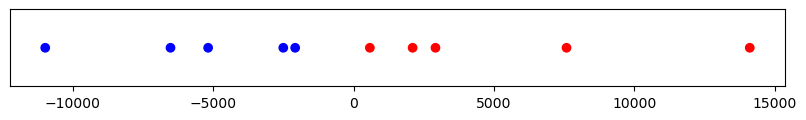

In [4]:
# Preprocessing
X = Person[1]['raw']
y = Person[1]['Label']
X = PCA(n_components=1).fit_transform(np.mean(X, axis=1))

# Train and test
classifier = LogisticRegression()
train_and_test(X, y, classifier)

# Plot 
plt.figure(figsize=(10,1))
plt.scatter(X, np.zeros_like(X), c=y, cmap='bwr')
plt.yticks([])
plt.show()

## Person3

100 tests mean accuracy: 92.0%

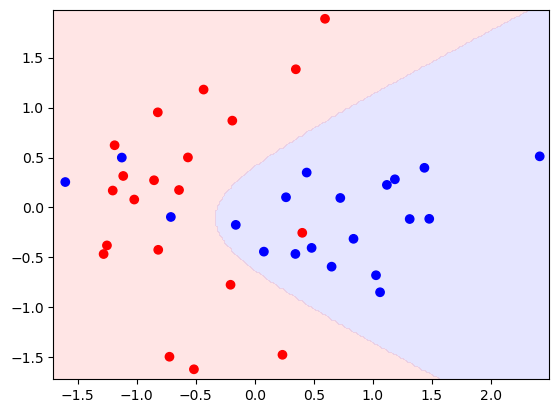

In [5]:
# Preprocessing
freq = [0, 3, 6, 7, 8, 9, 21, 25, 26, 29, 31, 32, 35, 36, 37, 45, 46, 48]
pair = [1, 2, 5, 6, 9, 10, 20, 24, 25, 26, 27, 33, 34, 35, 42, 45, 48, 50]
X = Person[2]['OS']
y = Person[2]['Label']
X = X[:, :, freq, :][:, pair]
X = np.mean(X, axis=-1)
X = X.reshape(X.shape[0], -1)
X = np.log(X)
X = PCA(n_components=2).fit_transform(X)

# Train and test
classifier = GaussianNB()
train_and_test(X, y, classifier, stratify=y)

# Plot
h = .02  # step size in the mesh
x_min, x_max = X[:, 0].min() - .1, X[:, 0].max() + .1
y_min, y_max = X[:, 1].min() - .1, X[:, 1].max() + .1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
Z = classifier.fit(X, y).predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
plt.contourf(xx, yy, Z, cmap='bwr', alpha=0.2)
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='bwr')
plt.show()

## Person4

100 tests mean accuracy: 97.0%

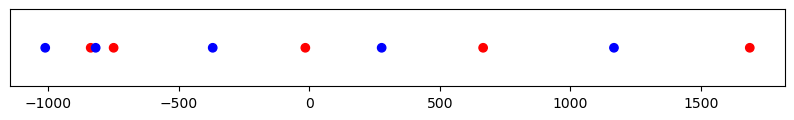

In [6]:
# Model
class MyClassifier:
    def fit(self, X, y):
        self.X = X
        self.y = y
        return self
    def predict(self, X):
        return ~self.y[np.argmin(np.sum(np.abs(X[:, np.newaxis] - self.X), axis=-1), axis=-1)]
    def score(self, X, y):
        return np.mean(self.predict(X) == y)

# Preprocessing
X = Person[3]['raw']
y = Person[3]['Label']
X = PCA(n_components=1).fit_transform(np.mean(X, axis=2))

# Train and Test
train_and_test(X, y, classifier=MyClassifier())

# Plot
plt.figure(figsize=(10,1))
plt.scatter(X, np.zeros_like(X), c=y, cmap='bwr')
plt.yticks([])
plt.show()

## Result

| Person | 1 | 2 | 3 | 4 |
| --- | --- | --- | --- | --- |
| Data | OS | raw | OS | raw |
| Use PCA | False | True | True | True |
| Use mean of time | True | False | True | True |
| Use Mean of channels | True | True | False | False |
| Classifier | SVM | Logistic Regression | Naive Bayes | Self-Implemented |
| Accuracy | 95.8% | 100% | 92.0% | 97.0% |

# Common Design On Each Person
Inspire of the previous preprocess of Person1

## (Pair, Freq) Selection

In [7]:
classifier = GaussianNB()

### Iterate through each (Pair, Freq) pair
The following cell may take a while to run. Please be patient. Or you can skip it to use the precalculated data.

In [8]:
pair_freq_res = np.empty((4, 54, 52))
for j in range(4):
    for pair, freq in it.product(range(54), range(52)):
        X = Person[j]['OS'][:, pair, freq]
        y = Person[j]['Label']
        X = np.mean(X, axis=-1).reshape(X.shape[0], -1)
        pair_freq_res[j, pair, freq] = train_and_test(X, y, classifier, stratify=y, verbose=False)
np.save('pair_freq_res.npy', pair_freq_res)

### Iterate through the most accurate j (Pair,Freq) pairs
The following cell may take a while to run. Please be patient. Or you can skip it to use the precalculated data.

In [9]:
pair_freq_res = np.load('pair_freq_res.npy')
pair_freq_res_bound = np.empty((4, 1000))
pair_freq_res_bound[:, 0] = 0
for j in range(4):
    for c in range(1, 1000):
        label = np.argsort(-pair_freq_res[j].reshape(-1))[:c]
        X = Person[j]['OS']
        y = Person[j]['Label']
        X = np.mean(X, axis=-1)
        X = X.reshape(X.shape[0], -1)
        X = X[:, label.reshape(-1)]
        pair_freq_res_bound[j, c] = train_and_test(X, y, classifier, N=100, verbose=False)
np.save('pair_freq_res_bound.npy', pair_freq_res_bound)

### Plot results

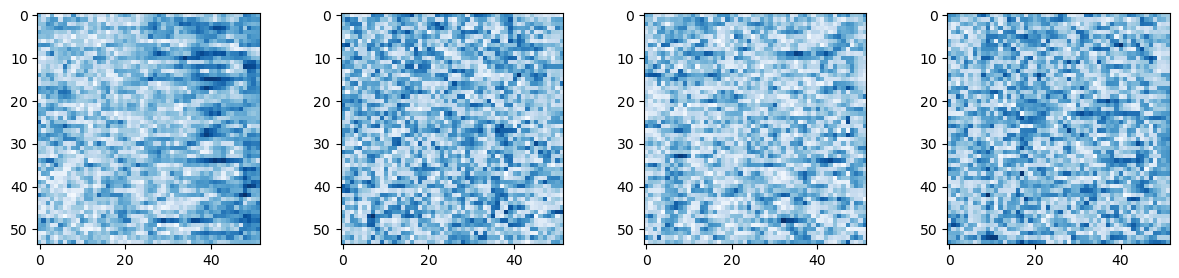

In [10]:
pair_freq_res = np.load('pair_freq_res.npy')
plt.figure(figsize=(15, 3))
for j in range(4):
    plt.subplot(1, 4, j+1)
    plt.imshow(pair_freq_res[j], cmap='Blues')
plt.show()

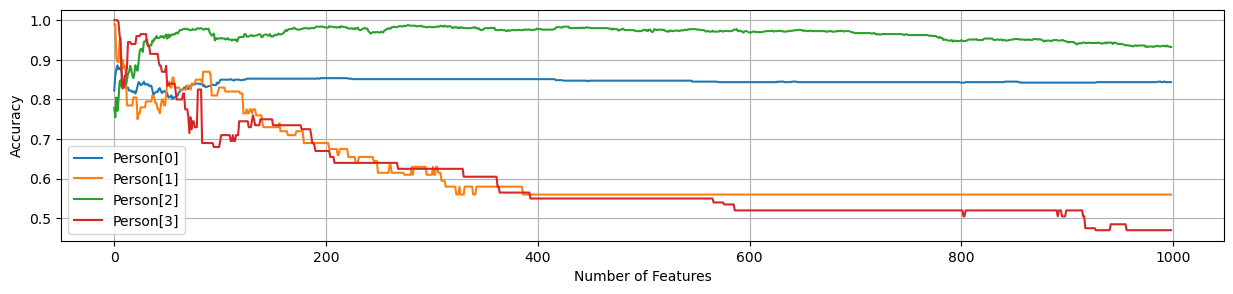

In [11]:
pair_freq_res_bound = np.load('pair_freq_res_bound.npy')
plt.figure(figsize=(15,3))
plt.plot(pair_freq_res_bound[:, 1:].T)
plt.grid(True)
plt.legend([f'Person[{i}]' for i in range(4)])
plt.xlabel('Number of Features')
plt.ylabel('Accuracy')
plt.show()

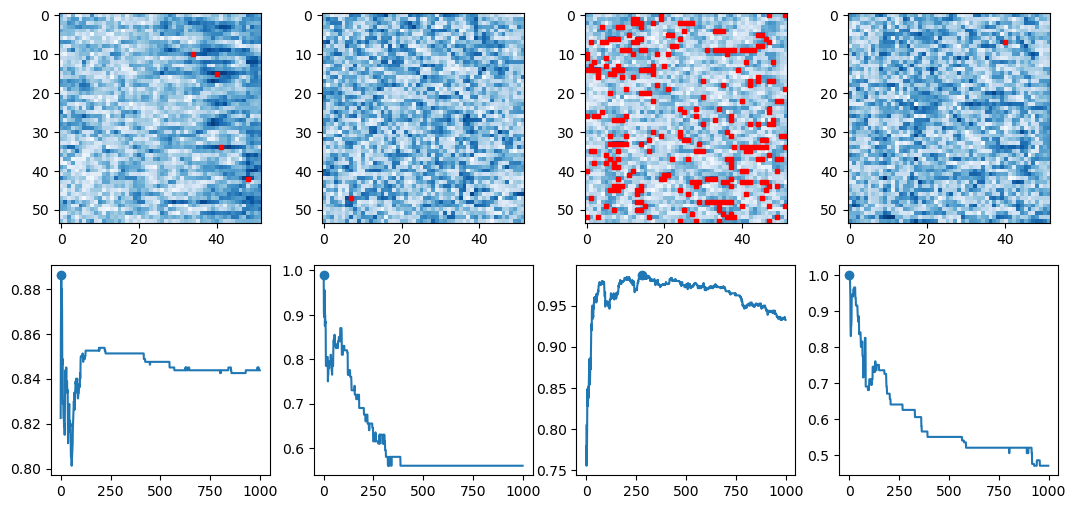

In [12]:
plt.figure(figsize=(13, 6))
for j, c in enumerate(np.argmax(pair_freq_res_bound, axis=1)):
    pair, freq = np.divmod(np.argsort(-pair_freq_res[j].reshape(-1))[:c], 52)
    plt.subplot(2, 4, j+1)
    plt.imshow(pair_freq_res[j], cmap='Blues')
    plt.scatter(freq, pair, c='r', marker='s', s=5)

for j in range(4):
    plt.subplot(2, 4, j+5)
    plt.plot(pair_freq_res_bound[j, 1:])
    max_x = np.argmax(pair_freq_res_bound[j])
    max_y = pair_freq_res_bound[j, max_x]
    plt.scatter([max_x], [max_y])
plt.show()


### Apply Seleted (Pair, Freq)

In [13]:
classifier = GaussianNB()

for j, c in enumerate(np.argmax(pair_freq_res_bound, axis=1)):
    print(f'Person[{j}]: ',)
    label = np.argsort(-pair_freq_res[j].reshape(-1))[:c]
    X = Person[j]['OS']
    y = Person[j]['Label']
    X = np.mean(X, axis=-1)
    X = X.reshape(X.shape[0], -1)
    X = X[:, label.reshape(-1)]
    train_and_test(X, y, classifier, stratify=y)

Person[0]:

100 tests mean accuracy: 88.2%

Person[1]:

100 tests mean accuracy: 100.0%

Person[2]:

100 tests mean accuracy: 98.8%

Person[3]:

100 tests mean accuracy: 100.0%

### Result

| Person | 1 | 2 | 3 | 4 |
| --- | --- | --- | --- | --- |
| Accuracy | 88.2% | 100% | 98.8% | 100% |

## (Pair,) * (Freq,) Selection

In [14]:
classifier = SVC(C=6)

### Iterate through Pairs

The following cell may take a while to run. Please be patient. Or you can skip it to use the precalculated data.

In [15]:
pair_res = np.empty((4, 54))
for j in range(4):
    for pair in range(54):
        X = Person[j]['OS'][:, pair]
        y = Person[j]['Label']
        X = np.mean(X, axis=(-1, -2)).reshape(X.shape[0], -1)
        pair_res[j, pair] = train_and_test(X, y, classifier, stratify=y, verbose=False)

np.save('pair_res.npy', pair_res)

### Iteratively extend Freqs and Pairs
The following cell may take a while to run. Please be patient. Or you can skip it to use the precalculated data.

In [16]:
pair_res = np.load('pair_res.npy')
freq_res = np.empty((4, 52))

pair_label = np.empty(4, dtype=np.object_)
freq_label = np.empty(4, dtype=np.object_)
label = [pair_label, freq_label]
accs = [pair_res, freq_res]

for j in range(4):
    print(f"Person[{j}]")
    label[0][j] = np.array([np.argmax(pair_res[j])])
    label[1][j] = np.array([], dtype=int)

    acc = 0
    cur = 1
    updated = False
    while True:
        size = 52 if cur==1 else 54
        accs[cur][j] = np.ones(size) * acc
        for p in range(size):
            if p in label[cur][j]:
                continue
            X = Person[j]['OS'][:, label[0][j]][:, :, np.append(label[1][j], [p])] if cur==1 else \
                Person[j]['OS'][:, np.append(label[0][j], [p])][:, :, label[1][j]]
            y = Person[j]['Label']
            X = np.mean(X, axis=-1).reshape(X.shape[0], -1)
            accs[cur][j, p] = train_and_test(X, y, classifier, stratify=y, verbose=False)
        if np.any(accs[cur][j] > acc):
            p = np.argmax(accs[cur][j])
            label[cur][j] = np.sort(np.append(label[cur][j], [p]))
            acc = accs[cur][j, p]
            print(f'{acc:.1%}', label[0][j], label[1][j])
            updated = True
            cur = 1 - cur
        elif updated:
            updated = False
            cur = 1 - cur
        else:
            break

[pair_label, freq_label] = label

np.save('pair_label.npy', pair_label)
np.save('freq_label.npy', freq_label)

Person[0]

78.9% [3] [41]

83.9% [ 3 26] [41]

86.4% [ 3 26] [ 3 41]

88.5% [ 3 26 47] [ 3 41]

93.0% [ 3 26 47] [ 3 30 41]

94.1% [ 3 26 47] [ 3 30 41 48]

96.8% [ 3  7 26 47] [ 3 30 41 48]

97.1% [ 3  7 26 47] [ 3 30 41 44 48]

97.8% [ 3  5  7 26 47] [ 3 30 41 44 48]

98.1% [ 3  5  7 26 47] [ 3 20 30 41 44 48]

Person[1]

93.5% [46] [50]

100.0% [38 46] [50]

Person[2]

62.6% [4] [21]

75.6% [ 4 41] [21]

76.8% [ 4 41] [11 21]

78.1% [ 4 36 41] [11 21]

80.6% [ 4  5 36 41] [11 21]

80.9% [ 4  5  8 36 41] [11 21]

84.0% [ 4  5  8 36 41] [11 21 22]

Person[3]

90.5% [37] [17]

92.5% [12 37] [17]

94.0% [12 37] [17 32]

100.0% [12 30 37] [17 32]

### Plot results

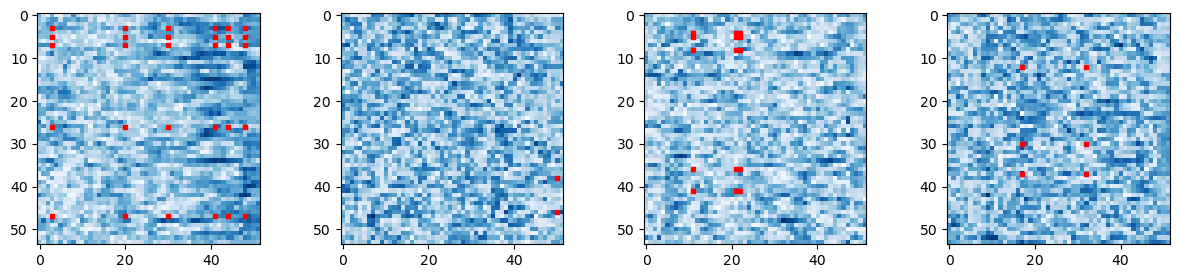

In [17]:
pair_label = np.load('pair_label.npy', allow_pickle=True)
freq_label = np.load('freq_label.npy', allow_pickle=True)
plt.figure(figsize=(15, 3))
for j in range(4):
    pair, freq = np.meshgrid(pair_label[j], freq_label[j])
    plt.subplot(1, 4, j+1)
    plt.imshow(pair_freq_res[j], cmap='Blues')
    plt.scatter(freq, pair, c='r', marker='s', s=5)


### Apply model

In [18]:
classifier = SVC(C=6)

for j in range(4):
    print(f'Person[{j}]')
    X = Person[j]['OS'][:, pair_label[j]][:, :, freq_label[j]]
    y = Person[j]['Label']
    X = np.mean(X, axis=-1)
    X = X.reshape(X.shape[0], -1)
    train_and_test(X, y, classifier, stratify=y)

Person[0]

100 tests mean accuracy: 98.1%

Person[1]

100 tests mean accuracy: 100.0%

Person[2]

100 tests mean accuracy: 84.0%

Person[3]

100 tests mean accuracy: 100.0%

### Result

| Person | 1 | 2 | 3 | 4 |
| --- | --- | --- | --- | --- |
| Accuracy | 98.1% | 100% | 84.0% | 100% |

# Best Test Accuracy for Each Person

|  | Person1 | Person2 | Person3 | Person4 |
| --- | --- | --- | --- | --- |
| Classifier | SVM | Naive Bayes | Naive Bayes | Naive Bayes |
| Accuracy | 98.1% | 100% | 98.8% | 100% |

# Common Design On All Data

In [19]:
OS = np.concatenate([Person[i]['OS'] for i in range(4)], axis=0)
y = np.concatenate([Person[i]['Label'] for i in range(4)], axis=0)
OS = np.mean(OS, axis=-1)
OS_ravel = OS.reshape(-1, 54*52)

## (Pair, Freq) Selection

In [20]:
classifier = SVC(C=6)

### Iterate through each (Pair,Freq) pair
The following cell may take a while to run. Please be patient. Or you can skip it to use the precalculated data.

In [21]:
pair_freq_res = np.empty((54, 52))
for pair, freq in it.product(range(54), range(52)):
    X = OS[:, pair, freq].reshape(-1, 1)
    pair_freq_res[pair, freq] = train_and_test(X, y, classifier, stratify=y, verbose=False)

np.save('mixed_pair_freq_res.npy', pair_freq_res)

### Plot results

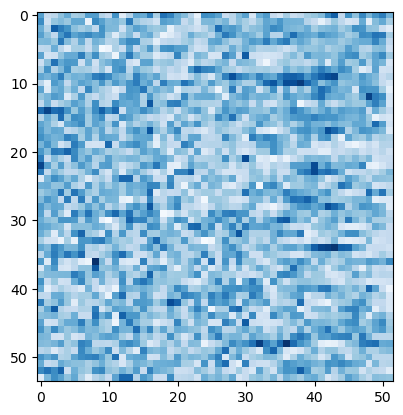

In [22]:
pair_freq_res = np.load('mixed_pair_freq_res.npy')
plt.imshow(pair_freq_res, cmap='Blues')
plt.show()

### Iterate through the most accurate j (Pair,Freq) pairs
The following cell may take a while to run. Please be patient. Or you can skip it to use the precalculated data.

In [23]:
pair_freq_res = np.load('mixed_pair_freq_res.npy')
pair_freq_res_ravel = pair_freq_res.ravel()
pair_freq_res_bound = np.empty(1000)
pair_freq_res_bound[0] = 0
arg_decent = np.argsort(-pair_freq_res.ravel())

for c in range(1, 1000):
    label = arg_decent[:c]
    X = OS_ravel[:, label]
    pair_freq_res_bound[c] = train_and_test(X, y, classifier, N=100, verbose=False)
np.save('mixed_pair_freq_res_bound.npy', pair_freq_res_bound)

### Plot results

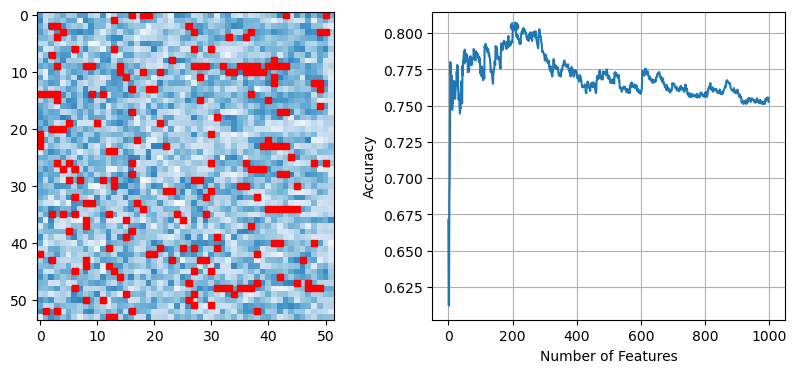

In [24]:
pair_freq_res = np.load('mixed_pair_freq_res.npy')
pair_freq_res_bound = np.load('mixed_pair_freq_res_bound.npy')
c = np.argmax(pair_freq_res_bound)
pair, freq = np.divmod(np.argsort(-pair_freq_res.ravel())[:c], 52)

plt.figure(figsize=(10,4))
plt.subplot(1, 2, 1)
plt.imshow(pair_freq_res, cmap='Blues')
plt.scatter(freq, pair, c='r', marker='s', s=20)

plt.subplot(1, 2, 2)
plt.plot(pair_freq_res_bound[1:])
plt.scatter([c], [pair_freq_res_bound[c]])
plt.grid(True)
plt.xlabel('Number of Features')
plt.ylabel('Accuracy')
plt.show()


### Apply Seleted (Pair, Freq)

In [25]:
c = np.argmax(pair_freq_res_bound)
X = OS_ravel[:, np.argsort(-pair_freq_res.ravel())[:c]]
res = train_and_test(X, y, classifier, stratify=y)

100 tests mean accuracy: 80.0%

## (Pair,) * (Freq,) Selection

In [26]:
classifier = SVC(C=6)

### Iterate through Pairs

In [27]:
pair_res = np.empty((54))
freq_res = np.empty((52))
for pair in range(54):
    X = OS[:, pair]
    pair_res[pair] = train_and_test(X, y, classifier, stratify=y, verbose=False)

### Iteratively extent Freqs and Pairs

In [28]:
pair_label = np.array([np.argmax(pair_res)])
freq_label = np.array([], dtype=int)
label = [pair_label, freq_label]
accs = [pair_res, freq_res]

acc = 0
cur = 1
updated = False
while True:
    size = 52 if cur==1 else 54
    accs[cur] = np.ones(size) * acc
    for p in range(size):
        if p in label[cur]:
            continue
        X = OS[:, label[0]][:, :, np.append(label[1], [p])] if cur==1 else \
            OS[:, np.append(label[0], [p])][:, :, label[1]]
        X = X.reshape(X.shape[0], -1)
        accs[cur][p] = train_and_test(X, y, classifier, stratify=y, verbose=False)
    if np.any(accs[cur] > acc):
        p = np.argmax(accs[cur])
        label[cur] = np.sort(np.append(label[cur], [p]))
        acc = accs[cur][p]
        print(f'{acc:.1%}', label[0], label[1])
        updated = True
        cur = 1 - cur
    elif updated:
        updated = False
        cur = 1 - cur
    else:
        break

[pair_label, freq_label] = label

np.save('mixed_pair_label.npy', pair_label)
np.save('mixed_freq_label.npy', freq_label)

65.5% [9] [43]

71.0% [ 9 23] [43]

73.3% [ 9 23] [21 43]

74.7% [ 9 23] [21 37 43]

75.3% [ 9 23 42] [21 37 43]

76.0% [ 9 23 42] [21 37 41 43]

77.0% [ 9 17 23 42] [21 37 41 43]

77.8% [ 9 17 23 42] [15 21 37 41 43]

78.5% [ 9 17 23 40 42] [15 21 37 41 43]

79.2% [ 9 17 23 40 42] [15 21 36 37 41 43]

80.9% [ 2  9 17 23 40 42] [15 21 36 37 41 43]

81.2% [ 2  5  9 17 23 40 42] [15 21 36 37 41 43]

81.7% [ 2  5  9 17 23 40 42] [15 16 21 36 37 41 43]

83.0% [ 2  5  9 17 23 37 40 42] [15 16 21 36 37 41 43]

83.8% [ 2  5  9 17 23 37 40 42 52] [15 16 21 36 37 41 43]

84.1% [ 2  5  9 17 23 37 40 42 52] [15 16 21 28 36 37 41 43]

84.7% [ 2  3  5  9 17 23 37 40 42 52] [15 16 21 28 36 37 41 43]

84.8% [ 2  3  5  9 17 23 37 40 42 52] [15 16 21 28 35 36 37 41 43]

### Plot results

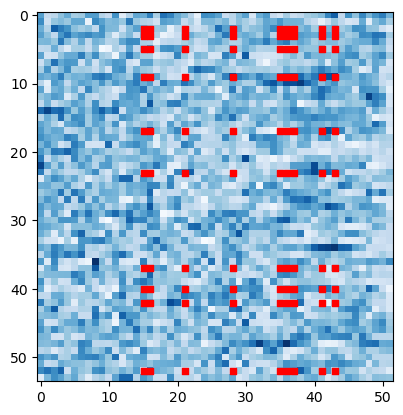

In [29]:
pair_label = np.load('mixed_pair_label.npy', allow_pickle=True)
freq_label = np.load('mixed_freq_label.npy', allow_pickle=True)
pair, freq = np.meshgrid(pair_label, freq_label)
plt.imshow(pair_freq_res, cmap='Blues')
plt.scatter(freq, pair, c='r', marker='s', s=20)
plt.show()

### Apply Model

In [30]:
X = OS[:, pair_label][:, :, freq_label]
X = X.reshape(X.shape[0], -1)
y = np.concatenate([Person[i]['Label'] for i in range(4)], axis=0)
res = train_and_test(X, y, classifier, stratify=y)

100 tests mean accuracy: 84.8%

In [31]:
for j in range(4):
    print(f'Person{j+1}')
    X = Person[j]['OS'][:, pair_label][:, :, freq_label]
    X = X.reshape(X.shape[0], -1)
    y = Person[j]['Label']
    train_and_test(X, y, classifier, stratify=y)    

Person1

100 tests mean accuracy: 74.0%

Person2

100 tests mean accuracy: 75.5%

Person3

100 tests mean accuracy: 64.0%

Person4

100 tests mean accuracy: 73.5%

## Result

The mean test accuracy of this model training on ...
| Mixed | Person1 | Person2 | Person3 | Person4 |
| --- | --- | --- | --- | --- |
| 84.8% | 74.0% | 75.5% | 64.0% | 73.5% |

# Best Test Accuracy On All Data: 84.8%